# MARS3888 - Finding and Using Online Datasets 

## Notebook 3


+ Part A: Connect to the OpeNDAP server (eReef) and download dataset from multi-files NetCDFs
    + Quality check data
+ Part B: Computing eReefs outputs seasonality for One Tree Island
    + Descriptive Statistics
    + Seasonality
    + Monthy distribtions
    + Linear Trends (rates of change)

#### Load the required Python libraries

First of all, load the necessary libraries:

+ numpy
+ matplotlib
+ cartopy
+ cmocean
+ seaborn
+ xarray
+ NetCFD4
+ datetime
+ scipy
+ pymannkendall

In [92]:
import os
import scipy
import numpy as np
import pandas as pd
import xarray as xr

import io
import requests

import datetime as dt
from dateutil.relativedelta import *

import netCDF4
from netCDF4 import Dataset, num2date

import cmocean

import seaborn as sns
import pymannkendall as mk

from matplotlib import pyplot as plt
# %config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12,7)
plt.ion()  # To trigger the interactive inline mode

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Part A: Connect to the OpeNDAP (eReef) server to extract dataset from multi-files NetCDFs

We query the server based on the OPeNDAP URL for a specific file “EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-YYYY-MM.nc”.

+ gbr4: we use the Hydrodynamic 4km model and daily data for the month specified

Like for our previous example we will use One Tree Reef:

In [41]:
site_lat = -23.508
site_lon = 152.091

We will use the available parameters from the eReefs dataset at the surface. This is done by defining the required depth index. For the GBR4 model this index is 16.

In [42]:
selectedDepthIndex = 16 # corresponding to -0.5 m

Checking from AIMS thredds server:

+ [Dataset THREDDS](https://thredds.ereefs.aims.gov.au/thredds/s3catalogue/aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/catalog.html)

The data are archived monthly from September 2010 to present. 

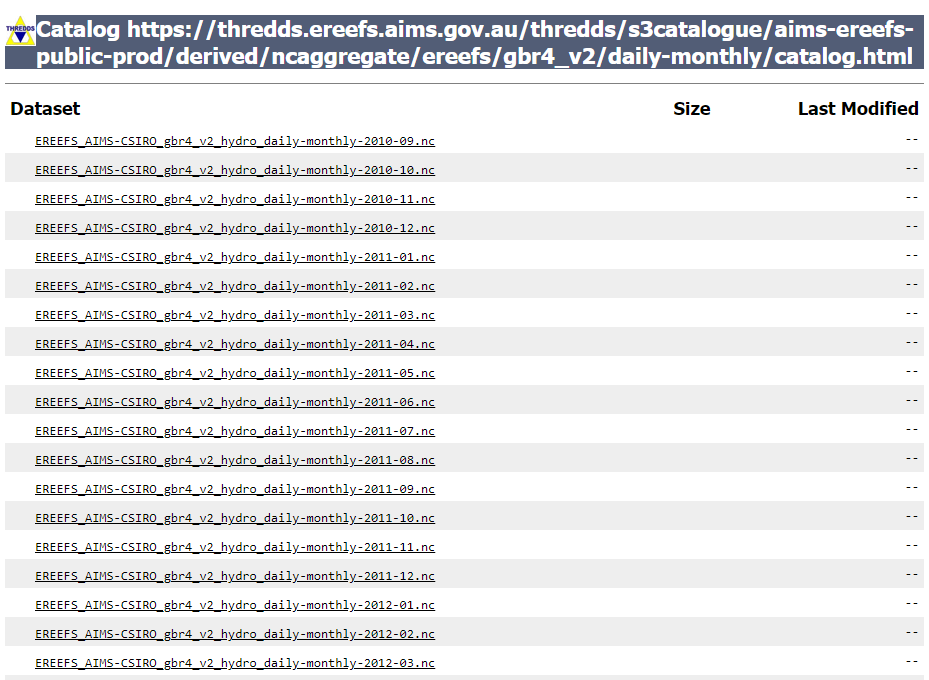

Load sinlge netCDF file to understand the structure

In [43]:
url="https://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-2010-09.nc"
ds = xr.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:      (time: 30, k: 17, latitude: 723, longitude: 491)
Coordinates:
    zc           (k) float64 ...
  * time         (time) datetime64[ns] 2010-08-31T14:00:00 ... 2010-09-29T14:...
  * latitude     (latitude) float64 -28.7 -28.67 -28.64 ... -7.096 -7.066 -7.036
  * longitude    (longitude) float64 142.2 142.2 142.2 ... 156.8 156.8 156.9
Dimensions without coordinates: k
Data variables:
    mean_cur     (time, k, latitude, longitude) float32 ...
    salt         (time, k, latitude, longitude) float32 ...
    temp         (time, k, latitude, longitude) float32 ...
    u            (time, k, latitude, longitude) float32 ...
    v            (time, k, latitude, longitude) float32 ...
    mean_wspeed  (time, latitude, longitude) float32 ...
    eta          (time, latitude, longitude) float32 ...
    wspeed_u     (time, latitude, longitude) float32 ...
    wspeed_v     (time, latitude, longitude) float32 ...
Attributes: (12/22)
    Conventions:                     CF-1.0
    Run_ID:                          2
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    aims_ncaggregate_buildDate:      2023-01-25T03:26:25+10:00
    aims_ncaggregate_datasetId:      products__ncaggregate__ereefs__gbr4_v2__...
    aims_ncaggregate_firstDate:      2010-09-01T00:00:00+10:00
    ...                              ...
    prefix_list_qudt__:              http://qudt.org/vocab/unit/
    shoc_version:                    v1.1 rev(5320M)
    technical_guide_link:            https://eatlas.org.au/pydio/public/aims-...
    technical_guide_publish_date:    2020-08-18
    title:                           eReefs AIMS-CSIRO GBR4 Hydrodynamic v2 d...
    DODS_EXTRA.Unlimited_Dimension:  time

Funtion to find index of nearest value to location in a numpy array.

In [44]:
def find_nearest(array, value):
    '''
    Find index of nearest value in a numpy array
    '''
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    return idx

To collect iteratively the information from each file we perform a while loop.

##### This cell takes a lot of time to run.

To speed up the process you might want to only extract the information for a restricted period of time and also some specific parameters (e.g. temperature or current speed…).

For the sake of the exercise, I have stored the output from this cell in a CSV file (OTI_timeseries.csv) so there is no need to run it again! Obviously depending of the reef you will chose in your project, you will need to run it.

NB: This will take time to process!!! We have provided you with an example data set from One Tree Reef

In [45]:
# Define starting and ending date of the netcdf file we want to load 

start_date = dt.date(2010, 9, 1)
end_date = dt.date(2023, 2, 1)
delta = relativedelta(months=+1)

In [46]:
# # Now perform a while loop to open the netcdf file and extract the relevant dataset for the site of interest
# step = True
# while start_date <= end_date:
    
#     # Read individual file from the OpeNDAP server
#     netCDF_datestr = str(start_date.year)+'-'+format(start_date.month, '02')
#     print('Processing time interval:',netCDF_datestr)
# #     inputFile = "https://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/monthly-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_monthly-monthly-"+netCDF_datestr+".nc"
#     inputFile = "https://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-"+netCDF_datestr+".nc"

#     start_date += delta    
#     nc_data = Dataset(inputFile, 'r')
#     ncdata = nc_data.variables
    
#     # Get parameters values for each single file
#     if step:
#         lat = ncdata['latitude'][:].filled(fill_value=0.)
#         lon = ncdata['longitude'][:].filled(fill_value=0.)
#         times = ncdata['time'][:]
#         selectedLatIndex = find_nearest(lat,site_lat)
#         selectedLonIndex = find_nearest(lon,site_lon)
#         current = nc_data.variables['mean_cur'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
#         wind = nc_data.variables['mean_wspeed'][:, selectedLatIndex, selectedLonIndex]
#         temperature = nc_data.variables['temp'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
#         salinity = nc_data.variables['salt'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
#     else:
#         days = ncdata['time'][:]
#         times = np.hstack((times,days))
#         dailyCurr = nc_data.variables['mean_cur'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
#         current = np.hstack((current,dailyCurr))
#         dailyWind = nc_data.variables['mean_wspeed'][:, selectedLatIndex, selectedLonIndex]
#         wind = np.hstack((wind,dailyWind))
#         dailyTemp = nc_data.variables['temp'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
#         temperature = np.hstack((temperature,dailyTemp))
#         dailySalt = nc_data.variables['salt'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
#         salinity = np.hstack((salinity,dailySalt))
#     step = False


# time = pd.to_datetime(times[:],unit='D',origin=pd.Timestamp('1990-01-01'))

# # Create a pandas dataframe containing the information from all the files
# df = pd.DataFrame(
#     data={
#         "date": time,
#         "current": current,
#         "wind": wind,
#         "salinity": salinity,
#         "temperature": temperature,
#     }
# )

# # Store these informations on a file in case you want to reuse them later on without having to 
# # rerun this cell...
# df.to_csv(
#         "OTI_timeseries.csv",
#         columns=["date", "current", "wind", "salinity", "temperature"],
#         sep=" ",
#         index=False,
#         header=1,
#     )
# df

Let’s load the a csv file for One Tree Island (2010-2023):

    NB: it took approx 3 hours to create 22 years of this dataset.

In [99]:
df = pd.read_csv(
        "OTI_timeseries.csv",
        sep=r"\s+",
        engine="c",
        header=0,
        na_filter=False,
        low_memory=False,
    )
df['date']= pd.to_datetime(df['date'], format="%Y-%m-%d")

We can visualise the file content in the Jupyter environment by simply calling the dataframe `df`:

In [55]:
df

,date,current,wind,salinity,temperature
0,2010-09-01,0.101399,5.131880,35.459198,21.884916
1,2010-09-02,0.230487,2.681918,35.508686,21.716635
2,2010-09-03,0.252419,2.745063,35.502716,21.791441
3,2010-09-04,0.401787,5.186341,35.477270,21.958267
4,2010-09-05,0.432971,4.300561,35.482044,22.008507
...,...,...,...,...,...
4536,2023-02-03,0.378959,5.248637,35.530674,26.571224
4537,2023-02-04,0.414192,4.683829,35.535995,26.763021
4538,2023-02-05,0.440176,5.438788,35.484802,26.673810
4539,2023-02-06,0.467718,9.375360,35.474117,26.302818


## Check Data for irregularities (optional)
First let's `.plot()` the data:

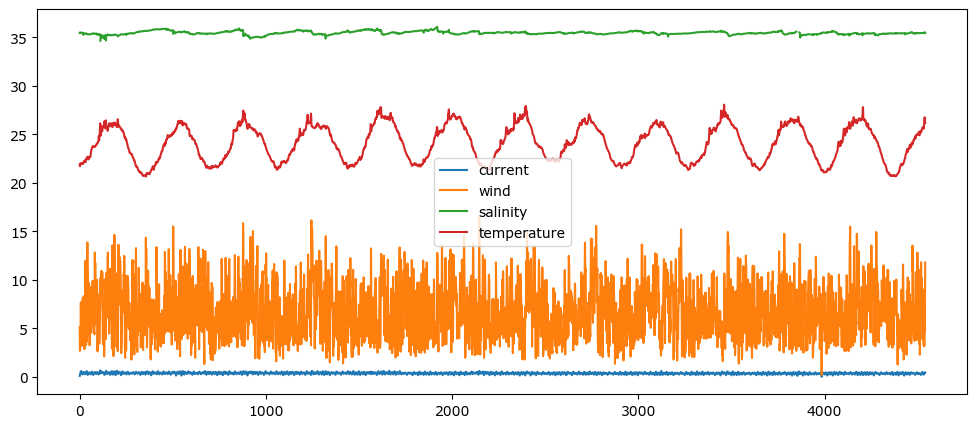

In [107]:
fig, ax1 = plt.subplots(figsize=(12, 5))

df.current.plot()
df.wind.plot()
df.salinity.plot()
df.temperature.plot()
ax1.legend(labels=["current", "wind", "salinity", "temperature"])

The salinity data contain some odd values.

To fix this let's look at `df.salinity`:

In [101]:
df.salinity.describe()

count    4.541000e+03
mean     3.512604e+34
std      5.907808e+35
min      1.475741e+00
25%      3.536789e+01
50%      3.544953e+01
75%      3.556974e+01
max      9.969210e+36
Name: salinity, dtype: float64

<AxesSubplot: >

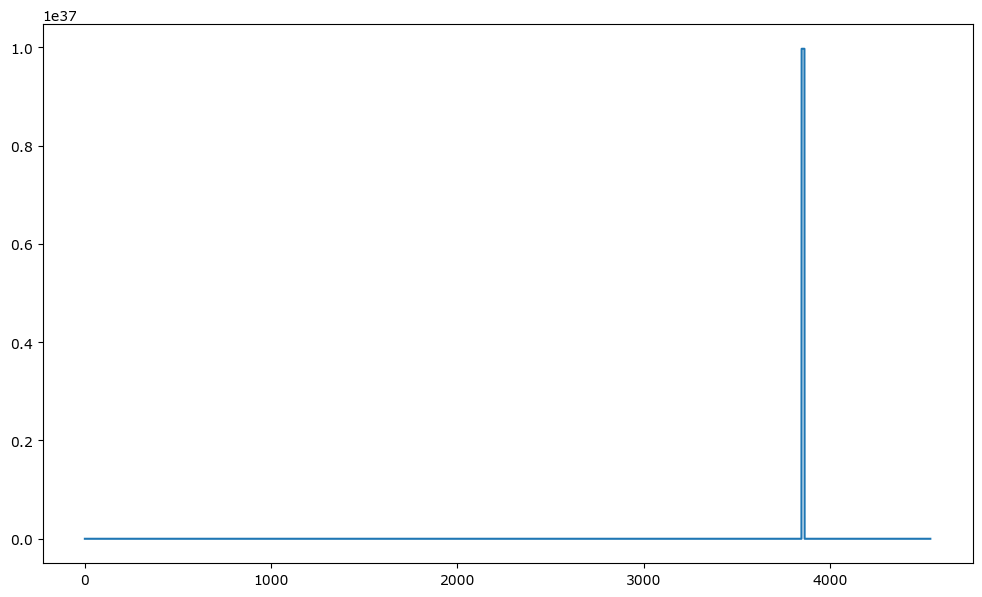

In [77]:
df.salinity.plot()

Lets now remove errors knowing that sea water has a salinity around 35:

In [121]:
df.loc[df['salinity'] > 40, 'salinity'] = np.nan # np.nan relaces these values with NaN
df.loc[df['salinity'] < 30, 'salinity'] = np.nan

Now that we have fixed salinity let's re-plot the data:

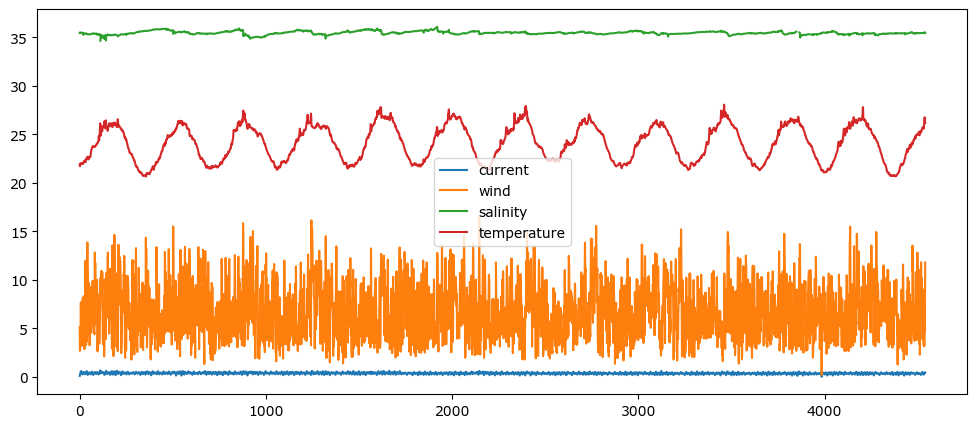

In [122]:
fig, ax1 = plt.subplots(figsize=(12, 5))

df.current.plot()
df.wind.plot()
df.salinity.plot()
df.temperature.plot()
ax1.legend(labels=["current", "wind", "salinity", "temperature"])

Now we can see that we need to fix `df.temperature` for any values under 15C. We have selected this value because we are looking at the tropics where SSTs are usually above 20C:

In [109]:
df.loc[df['temperature'] < 15, 'temperature'] = np.nan 

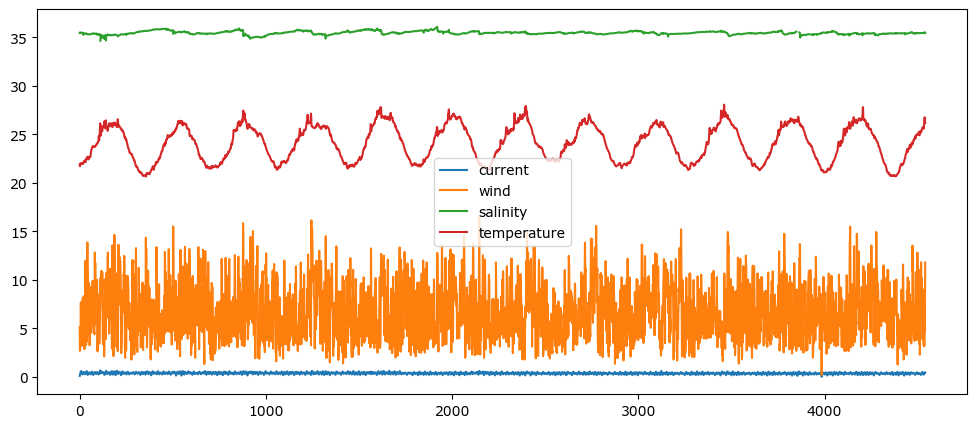

In [110]:
fig, ax1 = plt.subplots(figsize=(12, 5))

df.current.plot()
df.wind.plot()
df.salinity.plot()
df.temperature.plot()
ax1.legend(labels=["current", "wind", "salinity", "temperature"])

Sorted! now we can be confident that the data we have is good.

# Part B: Computing eReefs outputs seasonality

We can get basic descriptive stats using `.describe()`

In [112]:
df.describe()

,current,wind,salinity,temperature
count,4541.000000,4541.000000,4522.000000,4540.000000
mean,0.379609,6.784065,35.466435,24.075382
std,0.095277,2.711282,0.165542,1.808531
min,0.008718,0.221020,34.656887,20.661388
25%,0.309810,4.678720,35.367792,22.341377
50%,0.386734,6.411599,35.448625,24.120382
75%,0.450238,8.609639,35.568247,25.710337
max,0.658880,16.439035,36.094547,28.060698


## Time series with rolling average

We will first explore over time the evolution of the parameters by plotting time series. We will plot the raw data as well as the rolling mean value for a considered window (here we pick 30 days corresponding to a monthly mean).

In addition to the time series, we will also compute additional information:

+ Maximum parameter value
+ Mean parameter value
+ Median parameter value
+ 95th percentile parameter value

In [113]:
# Number of observations used for calculating the mean 
days = int(30) 

# Compute the rolling window for the mean
rolling = df.rolling(str(days) + "D", on="date", min_periods=1).mean()

current_roll = rolling["current"]
wind_roll = rolling["wind"]
salinity_roll = rolling["salinity"]
temperature_roll = rolling["temperature"]

# Let us store these means in a new datafame
timeseries = pd.DataFrame(
            data={
                "date": df['date'],
                "current": df['current'],
                "current_roll": current_roll,
                "wind": df['wind'],
                "wind_roll": wind_roll,
                "salinity": df['salinity'],
                "salinity_roll": salinity_roll,
                "temperature": df['temperature'],
                "temperature_roll": temperature_roll,
            }
        )

timeseries["day"] = timeseries["date"].dt.day
timeseries["month"] = timeseries["date"].dt.month
timeseries["year"] = timeseries["date"].dt.year

# Let's open the new dataframe
timeseries

,date,current,current_roll,wind,wind_roll,salinity,salinity_roll,temperature,temperature_roll,day,month,year
0,2010-09-01,0.101399,0.101399,5.131880,5.131880,35.459198,35.459198,21.884916,21.884916,1,9,2010
1,2010-09-02,0.230487,0.165943,2.681918,3.906899,35.508686,35.483942,21.716635,21.800776,2,9,2010
2,2010-09-03,0.252419,0.194769,2.745063,3.519620,35.502716,35.490200,21.791441,21.797664,3,9,2010
3,2010-09-04,0.401787,0.246523,5.186341,3.936301,35.477270,35.486967,21.958267,21.837815,4,9,2010
4,2010-09-05,0.432971,0.283813,4.300561,4.009153,35.482044,35.485983,22.008507,21.871953,5,9,2010
...,...,...,...,...,...,...,...,...,...,...,...,...
4536,2023-02-03,0.378959,0.348156,5.248637,6.430563,35.530674,35.456941,26.571224,25.482961,3,2,2023
4537,2023-02-04,0.414192,0.349369,4.683829,6.473073,35.535995,35.460108,26.763021,25.538738,4,2,2023
4538,2023-02-05,0.440176,0.351217,5.438788,6.484399,35.484802,35.461584,26.673810,25.596987,5,2,2023
4539,2023-02-06,0.467718,0.353889,9.375360,6.430683,35.474117,35.462640,26.302818,25.643658,6,2,2023


We can now plot the time series based on the above dataset.

Max surface current: 0.659 m/s
Mean surface current: 0.380 m/s
Median surface current: 0.387 m/s
95th percentile mean current: 0.529 m/s


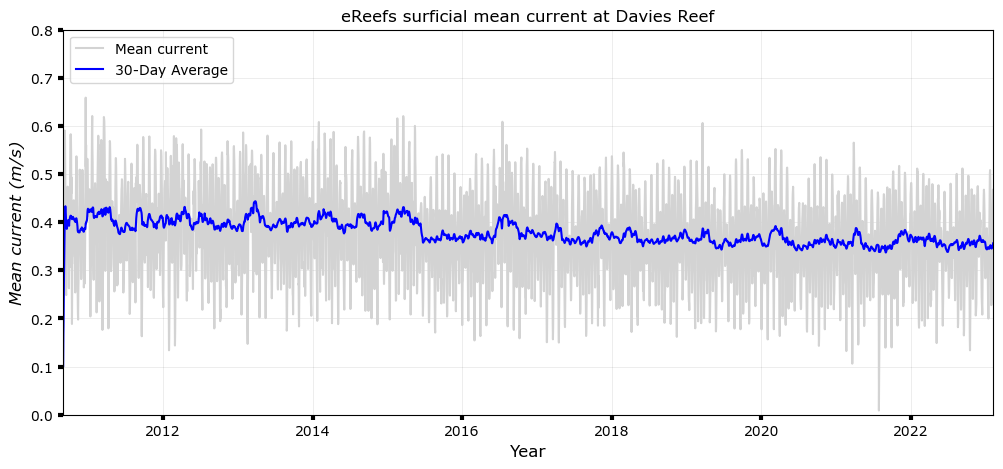

In [114]:
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(timeseries.date, timeseries.current, color="lightgrey", label="Mean current")
ax1.plot(
    timeseries.date,
    timeseries.current_roll,
    color="blue",
    label=str(days) + "-Day Average",
)
ax1.legend(
    labels=["Mean current", str(days) + "-Day Average"],
    loc="upper left",
)
ax1.set_ylabel("Mean current (m/s)", style="italic", fontsize=12)
ax1.set_ylim(0, 0.8)

print("Max surface current: {:0.3f} m/s".format(max(timeseries.current)))
print("Mean surface current: {:0.3f} m/s".format(np.mean(timeseries.current)))
print("Median surface current: {:0.3f} m/s".format(np.median(timeseries.current)))
print(
    "95th percentile mean current: {:0.3f} m/s".format(
        np.percentile(timeseries.current, 95)
    )
)
ax1.set_xlim(min(timeseries.date), max(timeseries.date))
ax1.set_xlabel("Year", fontsize=12)
ax1.grid(True, linewidth=0.5, color="k", alpha=0.1, linestyle="-")
ax1.tick_params(labelcolor="k", labelsize="medium", width=3)
plt.title('eReefs surficial mean current at Davies Reef')
plt.show()
#fig.savefig("OneTreeReefcurrentVariability", dpi=100)

Same goes with the other parameters:

Max mean wind: 16.439 m/s
Mean mean wind: 6.784 m/s
Median mean wind: 6.412 m/s
95th percentile mean wind: 11.689 m/s


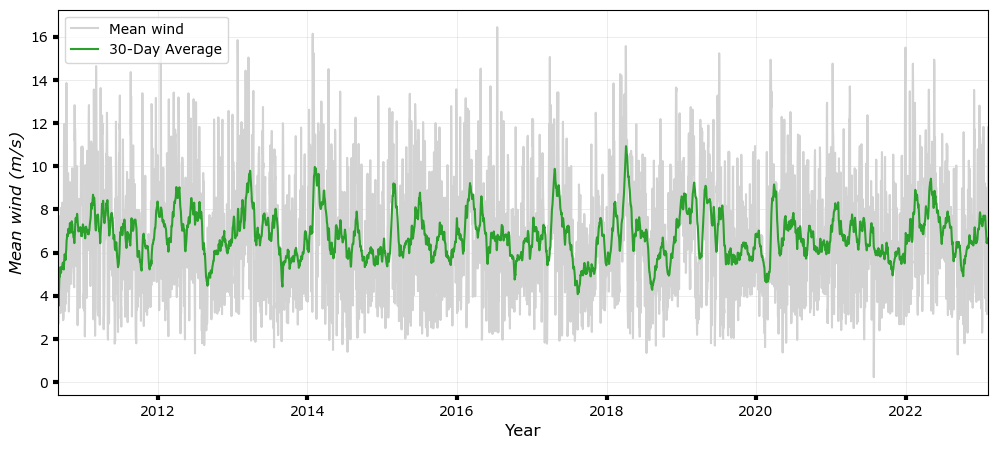

Max surface temperature: 28.061 deg. C
Mean surface temperature: 24.075 deg. C
Median surface temperature: nan deg. C
95th percentile mean surface temperature: nan deg. C


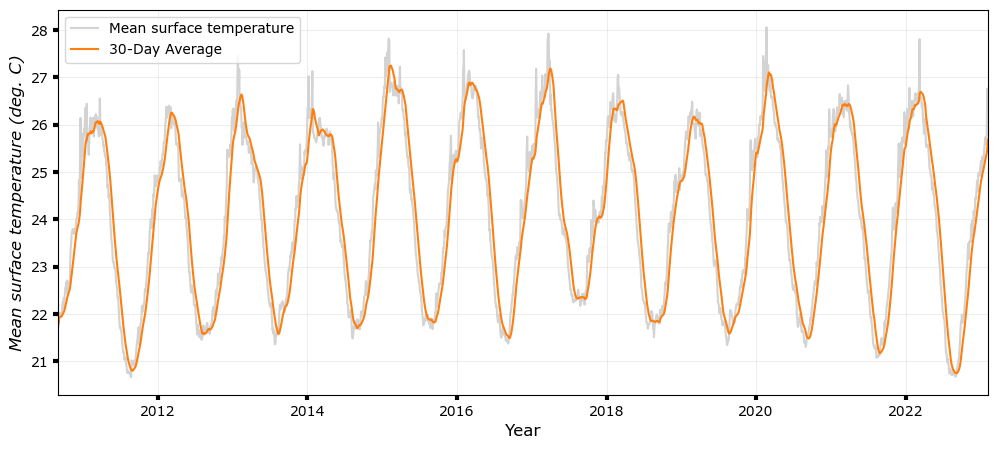

Max surface salinity: 36.095 PSU
Mean surface salinity: 35.466 PSU
Median surface salinity: nan PSU
95th percentile mean surface salinity: nan PSU


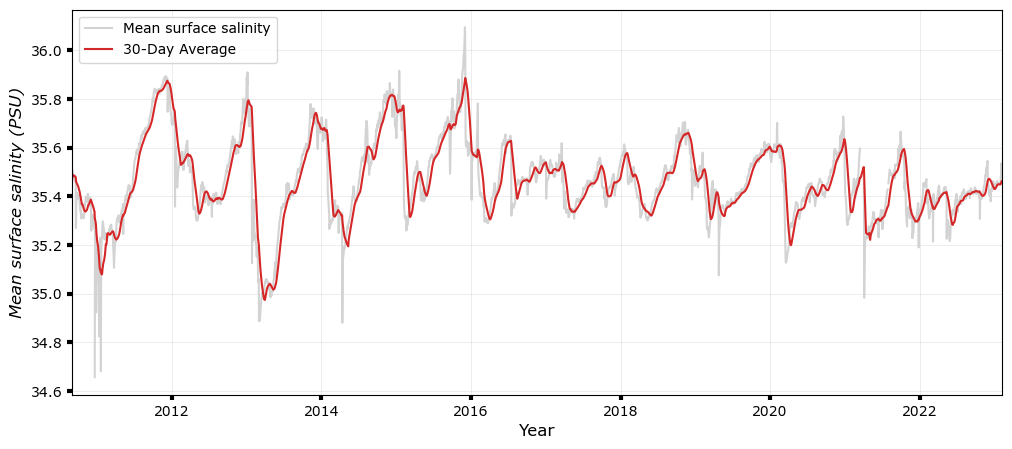

In [123]:
### WIND
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(timeseries.date, timeseries.wind, color="lightgrey", label="Mean wind")
ax1.plot(
    timeseries.date,
    timeseries.wind_roll,
    color="tab:green",
    label=str(days) + "-Day Average",
)
ax1.legend(
    labels=["Mean wind", str(days) + "-Day Average"],
    loc="upper left",
)
ax1.set_ylabel("Mean wind (m/s)", style="italic", fontsize=12)
print("Max mean wind: {:0.3f} m/s".format(max(timeseries.wind)))
print("Mean mean wind: {:0.3f} m/s".format(np.mean(timeseries.wind)))
print("Median mean wind: {:0.3f} m/s".format(np.median(timeseries.wind)))
print(
    "95th percentile mean wind: {:0.3f} m/s".format(
        np.percentile(timeseries.wind, 95)
    )
)
ax1.set_xlim(min(timeseries.date), max(timeseries.date))
ax1.set_xlabel("Year", fontsize=12)
# ax1.set_ylim(0, 20)
ax1.grid(True, linewidth=0.5, color="k", alpha=0.1, linestyle="-")
ax1.tick_params(labelcolor="k", labelsize="medium", width=3)
plt.show()

### TEMPERATURE
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(timeseries.date, timeseries.temperature, color="lightgrey", label="Mean wind")
ax1.plot(
    timeseries.date,
    timeseries.temperature_roll,
    color="tab:orange",
    label=str(days) + "-Day Average",
)
ax1.legend(
    labels=["Mean surface temperature", str(days) + "-Day Average"],
    loc="upper left",
)
ax1.set_ylabel("Mean surface temperature (deg. C)", style="italic", fontsize=12)
print("Max surface temperature: {:0.3f} deg. C".format(max(timeseries.temperature)))
print("Mean surface temperature: {:0.3f} deg. C".format(np.mean(timeseries.temperature)))
print("Median surface temperature: {:0.3f} deg. C".format(np.median(timeseries.temperature)))
print(
    "95th percentile mean surface temperature: {:0.3f} deg. C".format(
        np.percentile(timeseries.temperature, 95)
    )
)
ax1.set_xlim(min(timeseries.date), max(timeseries.date))
ax1.set_xlabel("Year", fontsize=12)
# ax1.set_ylim(20, 30)
ax1.grid(True, linewidth=0.5, color="k", alpha=0.1, linestyle="-")
ax1.tick_params(labelcolor="k", labelsize="medium", width=3)
plt.show()

### SALINITY
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(timeseries.date, timeseries.salinity, color="lightgrey", label="Mean wind")
ax1.plot(
    timeseries.date,
    timeseries.salinity_roll,
    color="tab:red",
    label=str(days) + "-Day Average",
)
ax1.legend(
    labels=["Mean surface salinity", str(days) + "-Day Average"],
    loc="upper left",
)
ax1.set_ylabel("Mean surface salinity (PSU)", style="italic", fontsize=12)
# ax1.set_ylim(35, 36)
print("Max surface salinity: {:0.3f} PSU".format(max(timeseries.salinity)))
print("Mean surface salinity: {:0.3f} PSU".format(np.mean(timeseries.salinity)))
print("Median surface salinity: {:0.3f} PSU".format(np.median(timeseries.salinity)))
print(
    "95th percentile mean surface salinity: {:0.3f} PSU".format(
        np.percentile(timeseries.salinity, 95)
    )
)
ax1.set_xlim(min(timeseries.date), max(timeseries.date))
ax1.set_xlabel("Year", fontsize=12)
ax1.grid(True, linewidth=0.5, color="k", alpha=0.1, linestyle="-")
ax1.tick_params(labelcolor="k", labelsize="medium", width=3)
plt.show()

# Seasonal Trends

In addition to time series, we can analyse the seasonal characteristics of eReefs parameters.

To do that we first need to group the previous data frame by month. We define a function `getSeason` that can be called for each parameter:

In [88]:
def getSeason(param):
    tdf = (timeseries.groupby(["year", "month"])[[param]]
                    .apply(np.mean)
                    .reset_index()
        )

    dfseason = tdf.pivot(index="year", columns="month", values=param)

    dfseason = dfseason.rename(
        columns={
            1: "January",
            2: "February",
            3: "March",
            4: "April",
            5: "May",
            6: "June",
            7: "July",
            8: "August",
            9: "September",
            10: "October",
            11: "November",
            12: "December",
        }
    )

    return dfseason

# Let's call the function
Current_season = getSeason('current')
Wind_season = getSeason('wind')
Temp_season = getSeason('temperature')
Salt_season = getSeason('salinity')


C:\Users\tfel6096\Anaconda3\envs\mars3888\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\tfel6096\Anaconda3\envs\mars3888\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\tfel6096\Anaconda3\envs\mars3888\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype,

# Plot Heatmaps

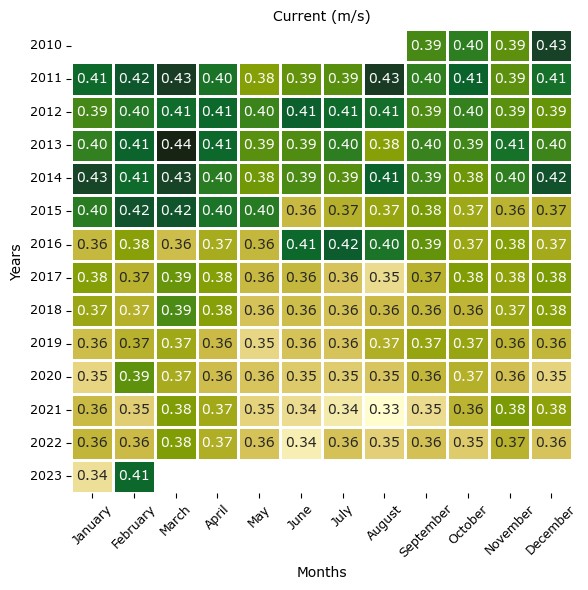

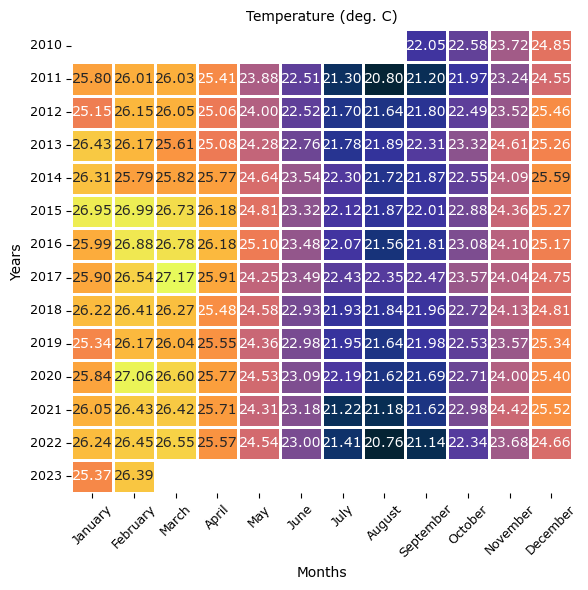

In [93]:
# Current
color = cmocean.cm.speed
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(
    Current_season, annot=True, fmt=".2f", cmap=color, linewidths=1, cbar=False
)
ax.set_title("Current (m/s)", fontsize=10)
ax.set_ylabel("Years", fontsize=10)
ax.set_xlabel("Months", fontsize=10)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.tight_layout()
plt.show()

# Temperature
color = cmocean.cm.thermal
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(
    Temp_season, annot=True, fmt=".2f", cmap=color, linewidths=1, cbar=False
)
ax.set_title("Temperature (deg. C)", fontsize=10)
ax.set_ylabel("Years", fontsize=10)
ax.set_xlabel("Months", fontsize=10)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.tight_layout()
plt.show()

# Plot Monthly Distributions


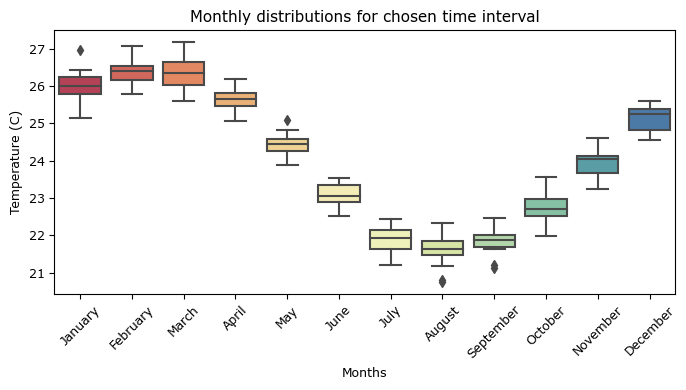

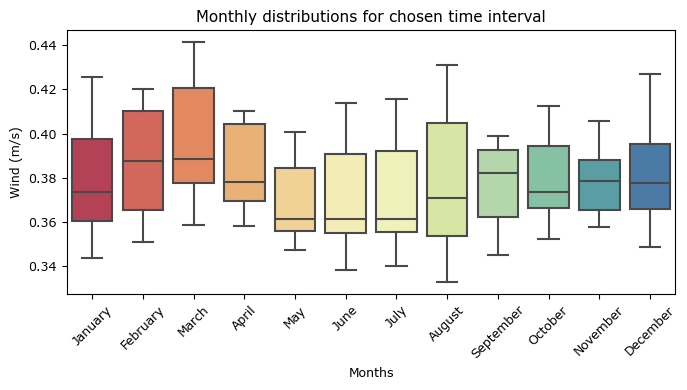

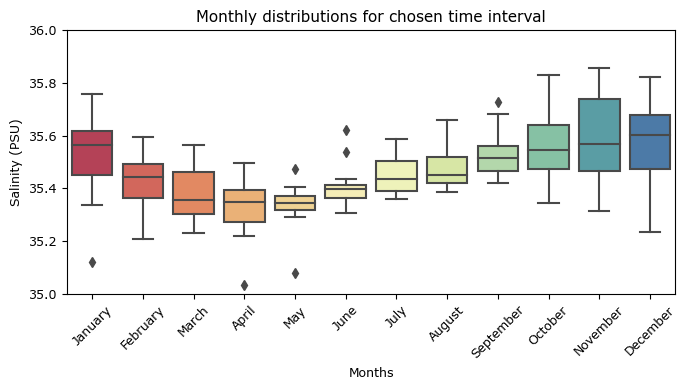

In [94]:
# Temp
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(data=Temp_season, palette="Spectral")
ax.set_title("Monthly distributions for chosen time interval", fontsize=11)
ax.set_ylabel("Temperature (C)", fontsize=9)
ax.set_xlabel("Months", fontsize=9)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.tight_layout()
plt.show()

# Wind
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(data=Current_season, palette="Spectral")
ax.set_title("Monthly distributions for chosen time interval", fontsize=11)
ax.set_ylabel("Wind (m/s)", fontsize=9)
ax.set_xlabel("Months", fontsize=9)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.tight_layout()
plt.show()

# Salinity
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(data=Salt_season, palette="Spectral")
ax.set_title("Monthly distributions for chosen time interval", fontsize=11)
ax.set_ylabel("Salinity (PSU)", fontsize=9)
ax.set_xlabel("Months", fontsize=9)
ax.set_ylim(35, 36)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.tight_layout()
plt.show()

# Standard deviation to the mean by months

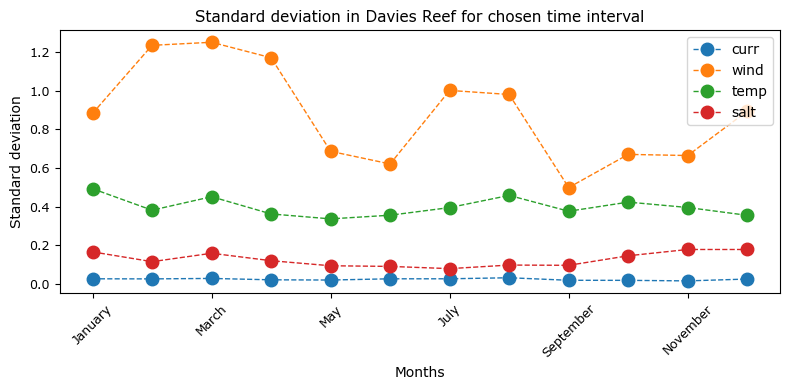

In [96]:
curr_sd = Current_season.std(axis=0)
wind_sd = Wind_season.std(axis=0)
temp_sd = Temp_season.std(axis=0)
salt_sd = Salt_season.std(axis=0)

# Make figure
fig, ax = plt.subplots(figsize=(8, 4))

curr_sd.plot(marker="o", linestyle="dashed", linewidth=1, markersize=9, label='curr')
wind_sd.plot(marker="o", linestyle="dashed", linewidth=1, markersize=9, label='wind')
temp_sd.plot(marker="o", linestyle="dashed", linewidth=1, markersize=9, label='temp')
salt_sd.plot(marker="o", linestyle="dashed", linewidth=1, markersize=9, label='salt')

ax.set_title("Standard deviation in Davies Reef for chosen time interval",fontsize=11)
ax.set_ylabel("Standard deviation", fontsize=10)
ax.set_xlabel("Months", fontsize=10)
# ax.set_ylim(0, 1.5)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.legend() #loc='upper right', bbox_to_anchor=(0.91, 0.91))
plt.tight_layout()
plt.show()

# Analyse Trends (Rates of Change)

In [118]:
curr_stack = Current_season.stack()
curr_trend = mk.seasonal_test(curr_stack, period=12)
print(" ")
print("Change in yearly current trend accounting for seasonality:")
print("    +           trend: ", curr_trend.trend)
print("    +    slope (cm/s /y): ",str(round(curr_trend.slope * 100.0, 2)))

wind_stack = Wind_season.stack()
wind_trend = mk.seasonal_test(wind_stack, period=12)
print(" ")
print("Change in yearly wind trend accounting for seasonality:")
print("    +           trend: ", wind_trend.trend)
print("    +    slope (cm/s /y): ",str(round(wind_trend.slope * 100.0, 2)))

temp_stack = Temp_season.stack()
temp_trend = mk.seasonal_test(temp_stack, period=12)
print(" ")
print("Change in yearly temperature trend accounting for seasonality:")
print("    +           trend: ", temp_trend.trend)
print("    +    slope (deg. C /y): ",str(round(temp_trend.slope, 2)))

salt_stack = Salt_season.stack()
salt_trend = mk.seasonal_test(salt_stack, period=12)
print(" ")
print("Change in yearly salinity trend accounting for seasonality:")
print("    +           trend: ", salt_trend.trend)
print("    +    slope (PSU /y): ",str(round(salt_trend.slope, 2)))

 
Change in yearly current trend accounting for seasonality:
    +           trend:  decreasing
    +    slope (cm/s /y):  -0.46
 
Change in yearly wind trend accounting for seasonality:
    +           trend:  no trend
    +    slope (cm/s /y):  -0.35
 
Change in yearly temperature trend accounting for seasonality:
    +           trend:  no trend
    +    slope (deg. C /y):  0.01
 
Change in yearly salinity trend accounting for seasonality:
    +           trend:  decreasing
    +    slope (PSU /y):  -0.01


Now you know the basics of extracting and exporting climate data to csv, and claculating statistics from NetCDF files.

### End of Notebook 3